# Pre-processing


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

Load libraries

In [53]:
from fastai.imports import *
from fastai.structured import *
from dill import dump_session
from functools import reduce

In [3]:
set_plot_sizes(12,14,16)

## Results pre-processing (tl;dr)

- `sales_granular.csv`:
    - For 906 POSs hourly sell data available from 8/3/15 until 6/25/17.
    - Sparse date --> aggregate per day, removing all 0s before first selling day and after last one.
    - On Sundays less shops open and thus less volume of sell. While Fridays seems a pick (not dependent on the #POSs.
    - Output: from wide to long format, with additional info about the date (i.e. Day of week)
- `Surroundings.json`:
    - For 546 POSs with 90 different type of surroundings.
    - Each surrounding can have multiple items, with different characteristics (non-structured data)
    - Output: structural and log format, selecting specific features (days open, type of surroundings, #item per type, ratings, price_level, and user_rating_total). Output for each POS with info of day open of each surroundings, and without (aggregating day of the week).

## Load sales data

The data provided need to be copied (or linked) in the folder `data/`

In [4]:
PATH = "data/"

Read and load in memory the `sales_granular` dataset. This is the first step to understand how to design the target variable.

In [5]:
df_raw = pd.read_csv(f'{PATH}sales_granular.csv', low_memory=False)

In [6]:
df_raw.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_raw.shape

(906, 11937)

Convert the data from wide to long format

In [8]:
df_melt = pd.melt(df_raw, id_vars='store_code', var_name='time', value_name='volume')

Split the columns to have date and hour. Moreover column date recognized as `datetime`.

In [9]:
%time df_melt['date'], df_melt['hour'] = df_melt['time'].str.split(' ',1).str
#df_melt['date'] = pd.to_datetime(df_melt.date, infer_datetime_format= True)

CPU times: user 27.3 s, sys: 1.41 s, total: 28.7 s
Wall time: 27.8 s


### EDA of sales data

Check how many missing values per store and day.

#### Missing values

In [10]:
# Selecting only fields to be summarized
flds = ['store_code', 'date', 'volume']
group_flds = ['store_code','date']

In [11]:
def summary_per_day(x):
    d = {}
    volume = x['volume']
    d['volume_day'] = volume.sum()
    d['volume_nan'] = volume.isnull().sum()
    d['volume_n'] = len(volume)
    return pd.Series(d, index=['volume_day', 'volume_nan', 'volume_n'])

df_aggregate_per_day = df_melt[flds].groupby(group_flds).apply(summary_per_day).reset_index()

In [12]:
df_aggregate_per_day['date'] = pd.to_datetime(df_aggregate_per_day.date, infer_datetime_format= True)

In [13]:
df_aggregate_per_day.sort_values(['store_code','date'],inplace=True)

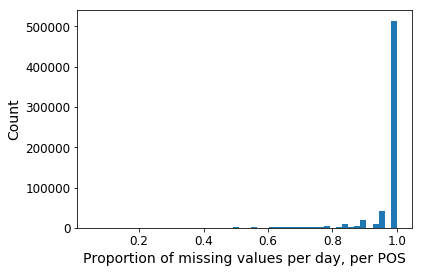

In [14]:
df_aggregate_per_day['Perc_nan'] = df_aggregate_per_day['volume_nan']/df_aggregate_per_day['volume_n']
plt.hist(df_aggregate_per_day.Perc_nan, bins=50);
plt.xlabel('Proportion of missing values per day, per POS')
plt.ylabel('Count');

In [15]:
df_aggregate_per_day.head()

,store_code,date,volume_day,volume_nan,volume_n,Perc_nan
615,249,2015-08-03,0.0,12.0,12.0,1.0
621,249,2015-08-04,0.0,13.0,13.0,1.0
623,249,2015-08-05,0.0,13.0,13.0,1.0
625,249,2015-08-06,0.0,12.0,12.0,1.0
627,249,2015-08-07,0.0,14.0,14.0,1.0


The majority are missing values. Need to investigate if it is by shop or in general.

In [16]:
def summary_per_shop(x):
    d = {}
    volume = x['volume_day']
    nan_perc = x['Perc_nan']
    d['volume_total'] = volume.sum()
    d['count_volumn_day_not_nan'] = (nan_perc != 1).sum()
    d['days_available'] = len(volume)
    return pd.Series(d, index=['volume_total', 'count_volumn_day_not_nan','days_available'])

df_aggregate_per_shop = df_aggregate_per_day.groupby('store_code').apply(summary_per_shop).reset_index()

In [17]:
df_aggregate_per_shop.head()

,store_code,volume_total,count_volumn_day_not_nan,days_available
0,249,18450.0,68.0,693.0
1,282,2880.0,29.0,693.0
2,425,810.0,10.0,693.0
3,1326,185340.0,341.0,693.0
4,1498,360.0,3.0,693.0


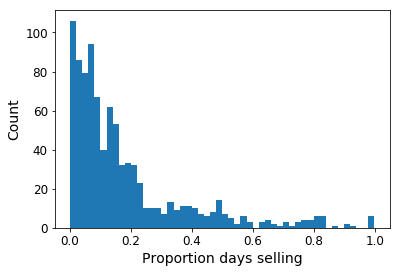

In [18]:
df_aggregate_per_shop['days_sell'] = df_aggregate_per_shop['count_volumn_day_not_nan']/df_aggregate_per_shop['days_available']

plt.hist(df_aggregate_per_shop.days_sell, bins=50);
plt.xlabel('Proportion days selling')
plt.ylabel('Count');

In [19]:
df_aggregate_per_shop.sort_values('days_sell').head(20)

,store_code,volume_total,count_volumn_day_not_nan,days_available,days_sell
62,11007,60.0,1.0,693.0,0.001443
16,3745,30.0,1.0,693.0,0.001443
750,32357,300.0,1.0,693.0,0.001443
21,4032,30.0,1.0,693.0,0.001443
494,26906,60.0,2.0,693.0,0.002886
15,3655,90.0,2.0,693.0,0.002886
566,28634,90.0,2.0,693.0,0.002886
195,19717,600.0,2.0,693.0,0.002886
396,24356,90.0,2.0,693.0,0.002886
190,19506,60.0,2.0,693.0,0.002886


Thus, the dataset contains several shops where less than 20% of the data are not missing. For example there are 4 POSs with only one day of selling information.

#### First choice: aggregate by day
As a first step we drop the information about hour, since we have sparse data.

Since several shop have short informative time series, __we delete all days before first sell and after the last sell__.
Ideally having the info about the time activity of the shop, or distribution time to that specific shop would help.

In [20]:
def take_informative_series(x):
    # Remove all 0s before the fist sell
    x = x.loc[x[(x.volume_day != 0)].first_valid_index():]
    # Remove all 0s after the last sell
    x = x.loc[:x[(x.volume_day != 0)].last_valid_index()]
    return x

df_aggregate_per_day_short = df_aggregate_per_day.groupby('store_code').apply(take_informative_series).reset_index(drop = True)

Add information about date (i.e. which day of the week, of the year)

In [21]:
add_datepart(df_aggregate_per_day_short, 'date', drop=False)

In [22]:
df_aggregate_per_day_short.head()

,store_code,date,volume_day,volume_nan,volume_n,Perc_nan,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,249,2016-12-13,300.0,17.0,18.0,0.944444,2016,12,50,13,1,348,False,False,False,False,False,False,1481587200
1,249,2016-12-14,0.0,18.0,18.0,1.000000,2016,12,50,14,2,349,False,False,False,False,False,False,1481673600
2,249,2016-12-15,0.0,18.0,18.0,1.000000,2016,12,50,15,3,350,False,False,False,False,False,False,1481760000
3,249,2016-12-16,0.0,18.0,18.0,1.000000,2016,12,50,16,4,351,False,False,False,False,False,False,1481846400
4,249,2016-12-17,0.0,19.0,19.0,1.000000,2016,12,50,17,5,352,False,False,False,False,False,False,1481932800


#### Aggregate per day of the week

In [23]:
# Check if any days are closed for all the shops.
flds = ['store_code','volume_day','Dayofweek']

def summary_per_day(x):
    d = {}
    d['num_shops'] = x['store_code'].nunique()
    d['volumetot'] = x.volume_day.sum()
    return pd.Series(d, index=['num_shops', 'volumetot'])

df_aggregate_per_day_short_nozeros = df_aggregate_per_day_short[df_aggregate_per_day_short.volume_day!=0]
week_info = df_aggregate_per_day_short_nozeros[flds].groupby('Dayofweek').apply(summary_per_day).reset_index()

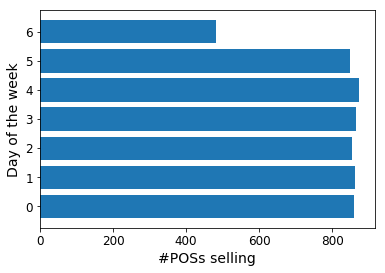

In [24]:
plt.barh(week_info.Dayofweek, week_info.num_shops);
plt.xlabel('#POSs selling');
plt.ylabel('Day of the week');

On __Sudays__, we have less POS open.

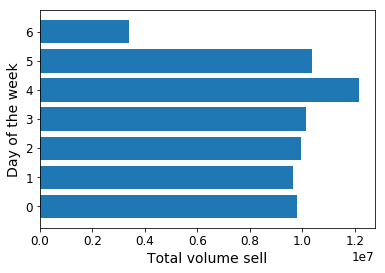

In [25]:
plt.barh(week_info.Dayofweek, week_info.volumetot);
plt.xlabel('Total volume sell');
plt.ylabel('Day of the week');

There is no day where all shops are closed. But on Sundays (`Dayofweek == 6`) we have less shops open and thus less volume.

But we see that there is an increase of selling on Friday.

## Load surroundings data

In [26]:
md_raw = pd.read_json(f'{PATH}Surroundings.json')

In [27]:
md_raw.head()

,store_code,surroundings
0,10055,"{'subway_station': [], 'department_store': [],..."
1,10077,"{'subway_station': [], 'department_store': [],..."
2,10079,"{'subway_station': [], 'department_store': [{'..."
3,10086,"{'subway_station': [], 'department_store': [],..."
4,10111,"{'subway_station': [], 'department_store': [],..."


In [28]:
md_raw.shape

(546, 2)

For each store we have a dictonary with similar keys of surrounding. Convert from wide to long.

In [29]:
def dict_to_df(x):
    d = x.surroundings
    return  pd.Series(pd.DataFrame(list(d.items())), index=list(d.keys())) 

In [30]:
df_surroundings = md_raw['surroundings'].apply(pd.Series)
md_long = pd.concat([md_raw.drop(['surroundings'], axis=1), df_surroundings], axis=1)

In [31]:
md_long.head()

,store_code,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,...,store,subway_station,synagogue,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
0,10055,[{'name': 'Fiduciaire Exacte & Gestion Comptab...,[],[],[],"[{'website': 'http://www.onegeeinfog.com/', 'n...","[{'website': 'https://www.ubs.com/ch/fr.html',...","[{'name': 'Mconseils SA', 'place_id': 'ChIJRz1...","[{'website': 'http://www.ubs.ch/', 'rating': 5...","[{'rating': 3.5, 'place_id': 'ChIJ8xHdm_1vjEcR...",...,[{'website': 'https://filialen.migros.ch/de/mi...,[],[],[],[],"[{'name': 'Chêne-Bourg, La Mousse', 'place_id'...","[{'name': 'Courir au Népal Sàrl', 'place_id': ...",[],[{'website': 'http://www.vet-chene-bougeries.c...,[]
1,10077,[],[],[],[],[],[],"[{'rating': 4.8, 'place_id': 'ChIJM8FbQe9vjEcR...",[],[],...,[{'website': 'http://www.coop.ch/fr/services/a...,[],[],[],[],"[{'name': 'Chêne-Bougeries, Montagne', 'place_...",[],[],[],[]
2,10079,[{'website': 'http://www.vd.ch/autorites/depar...,[],[],[],[],"[{'name': 'PickPost-Stelle', 'opening_hours': ...",[{'website': 'https://filialen.migros.ch/de/ta...,"[{'website': 'https://www.ubs.com/ch/fr.html',...",[{'website': 'https://www.facebook.com/Highlan...,...,"[{'website': 'http://www.denner.ch/', 'rating'...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Bel-Air', 'place...","[{'website': 'http://www.hotelplan.ch/FR/', 'r...",[],[],[]
3,10086,[],[],[],[],[],[],[],[],"[{'website': 'http://www.oubangui.com/', 'rati...",...,"[{'rating': 3.3, 'place_id': 'ChIJUW-HLeAxjEcR...",[],[],[],[],"[{'name': 'Bois-Gentil', 'place_id': 'ChIJK8fw...",[],[],[],[]
4,10111,[],[],[],[],[],[],[],[],[],...,"[{'name': 'lookemontre.com', 'opening_hours': ...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Plaisance', 'pla...",[],[],[],[]


In [32]:
md_long.shape

(546, 90)

We have 546 possible different types of surroundings.

### EDA of surroundings data

In [33]:
empty_ = df_surroundings.apply(lambda x: x.astype(str) != '[]', axis=0)

In [34]:
surroundings_type_summary = empty_.sum(axis = 0)
surroundings_type_summary = pd.DataFrame({'type':surroundings_type_summary.index, 'count':surroundings_type_summary.values}) 

surroundings_store_summary = empty_.sum(axis = 1)
surroundings_store_summary = pd.DataFrame({'store_code':surroundings_store_summary.index, 'count':surroundings_store_summary.values}) 


Distribution of number of shops for each types of surroundings

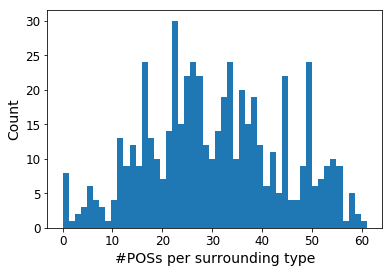

In [35]:
plt.hist(surroundings_store_summary['count'], bins = 50);
plt.xlabel('#POSs per surrounding type')
plt.ylabel('Count');

Distribution of number of surroundings for each shop

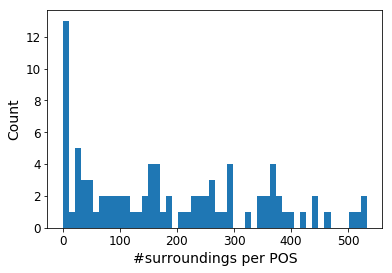

In [36]:
plt.hist(surroundings_type_summary['count'], bins = 50);
plt.xlabel('#surroundings per POS');
plt.ylabel('Count');

In [37]:
surrounding_keys = [set().union(*(d.keys() 
                                  for d in list(chain(*df_surroundings[i])))) 
                    for i in list(df_surroundings.columns)]
#unlist(list(md_long.accounting))
all_keys = set().union(*(list(x) for x in surrounding_keys))
all_keys

{'address_components',
 'formatted_address',
 'icon',
 'international_phone_number',
 'latitude',
 'longitude',
 'name',
 'opening_hours',
 'place_id',
 'price_level',
 'rating',
 'reviews',
 'types',
 'user_ratings_total',
 'website'}

As first pass we select only specific elements as possible features:

* `opening_hours`
* `price_level`
* `rating`
* `types`
* `user_ratings_total`

At first we do not consider the single `reviews`.

### Check opening hours of surroundings

In [38]:
surrounding_keys_list = [list(x) for x in surrounding_keys]

In [39]:
def get_types_with_feat(feature):
    filtered = [feature in x for x in surrounding_keys_list]
    return np.where(filtered)[0]

def get_example_feat(feat):
    series = df_surroundings.iloc[:,get_types_with_feat(feat)[0]]
    elements = [x for x in series.tolist() if x]
    elements = [item for sublist in elements for item in sublist]
    elements_with_key = [{k: d[k] for k in [feat] if k in d} for d in elements]
    elements_with_key = list(filter(None, elements_with_key))
    return elements_with_key[0][feat]

In [40]:
fld = 'opening_hours'
test = get_example_feat(fld)
test

{'open_now': False,
 'periods': [{'close': {'day': 1, 'time': '1700'},
   'open': {'day': 1, 'time': '0900'}},
  {'close': {'day': 2, 'time': '1700'}, 'open': {'day': 2, 'time': '0900'}},
  {'close': {'day': 3, 'time': '1700'}, 'open': {'day': 3, 'time': '0900'}},
  {'close': {'day': 4, 'time': '1700'}, 'open': {'day': 4, 'time': '0900'}},
  {'close': {'day': 5, 'time': '1700'}, 'open': {'day': 5, 'time': '0900'}}],
 'weekday_text': ['Monday: 9:00 AM – 5:00 PM',
  'Tuesday: 9:00 AM – 5:00 PM',
  'Wednesday: 9:00 AM – 5:00 PM',
  'Thursday: 9:00 AM – 5:00 PM',
  'Friday: 9:00 AM – 5:00 PM',
  'Saturday: Closed',
  'Sunday: Closed']}

In case of `opening_hours`, since we decided to work with aggregate per day, we select the open days of the week.
A function is needed to extract the necessary values

In [41]:
def get_open_days(dt):
    hours = dt['weekday_text']
    return np.where([x.split(': ',1)[1] != 'Closed' for x in hours])[0]

get_open_days(test)

array([0, 1, 2, 3, 4])

#### Check rating

In [42]:
fld = 'rating'
test = get_example_feat(fld)
test

2.5

No function is needed to extract the rating value.

#### Check types

In [43]:
fld = 'types'
test = get_example_feat(fld)
test

['accounting', 'finance', 'point_of_interest', 'establishment']

#### Check user ratings total

In [44]:
fld = 'user_ratings_total'
test = get_example_feat(fld)
test

2

#### Check price level

In [45]:
fld = 'price_level'
test = get_example_feat(fld)
test

2

### Reformatting surroundings data

In [46]:
df_surroundings.head()

,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,beauty_salon,...,store,subway_station,synagogue,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
0,[{'name': 'Fiduciaire Exacte & Gestion Comptab...,[],[],[],"[{'website': 'http://www.onegeeinfog.com/', 'n...","[{'website': 'https://www.ubs.com/ch/fr.html',...","[{'name': 'Mconseils SA', 'place_id': 'ChIJRz1...","[{'website': 'http://www.ubs.ch/', 'rating': 5...","[{'rating': 3.5, 'place_id': 'ChIJ8xHdm_1vjEcR...","[{'website': 'http://www.jadebeaute.com/', 'ra...",...,[{'website': 'https://filialen.migros.ch/de/mi...,[],[],[],[],"[{'name': 'Chêne-Bourg, La Mousse', 'place_id'...","[{'name': 'Courir au Népal Sàrl', 'place_id': ...",[],[{'website': 'http://www.vet-chene-bougeries.c...,[]
1,[],[],[],[],[],[],"[{'rating': 4.8, 'place_id': 'ChIJM8FbQe9vjEcR...",[],[],[],...,[{'website': 'http://www.coop.ch/fr/services/a...,[],[],[],[],"[{'name': 'Chêne-Bougeries, Montagne', 'place_...",[],[],[],[]
2,[{'website': 'http://www.vd.ch/autorites/depar...,[],[],[],[],"[{'name': 'PickPost-Stelle', 'opening_hours': ...",[{'website': 'https://filialen.migros.ch/de/ta...,"[{'website': 'https://www.ubs.com/ch/fr.html',...",[{'website': 'https://www.facebook.com/Highlan...,"[{'rating': 5, 'place_id': 'ChIJmxg6U4LPjUcR86...",...,"[{'website': 'http://www.denner.ch/', 'rating'...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Bel-Air', 'place...","[{'website': 'http://www.hotelplan.ch/FR/', 'r...",[],[],[]
3,[],[],[],[],[],[],[],[],"[{'website': 'http://www.oubangui.com/', 'rati...",[{'website': 'http://www.blattnerpodologue.ch/...,...,"[{'rating': 3.3, 'place_id': 'ChIJUW-HLeAxjEcR...",[],[],[],[],"[{'name': 'Bois-Gentil', 'place_id': 'ChIJK8fw...",[],[],[],[]
4,[],[],[],[],[],[],[],[],[],[],...,"[{'name': 'lookemontre.com', 'opening_hours': ...",[],[],[],[],"[{'name': 'Yverdon-les-Bains, Plaisance', 'pla...",[],[],[],[]


Function to extract needed filds

In [47]:
keys_of_interest = ['opening_hours', 'price_level', 'rating','types','user_ratings_total']
default_days = np.array([0,1,2,3,4])

def get_values(kk,vv):
    if kk == 'opening_hours':
        return get_open_days(vv)
    else:
        return vv

def filter_surroundings(ll, set_default_days = True):
    ## First select only elements with keys of interest
    selected_elements = [{k: i[k] for k in keys_of_interest if k in i.keys()} for i in ll]
    ## Then extract values in corresponding format of interest
    selected_elements = [{k: get_values(k,v) for k, v in elem.items()} for elem in selected_elements]
    ## Add default opening days if True
    if set_default_days:
        for i in selected_elements:
            if 'opening_hours' not in i.keys():
                i['opening_hours'] = default_days
    return selected_elements

In [48]:
df_surr_filtered = df_surroundings.applymap(filter_surroundings)

#### Aggregate surrouding without open day information

In [49]:
def summarize_metadata(x):
    d = {}
    to_summarize = {}
    idx = ['has','n']
    d['has'] = 0
    d['n'] = 0
    nn = len(x)
    if nn > 0:
        d['has'] = 1
        d['n'] = nn
        keys_to_summarize = list(set().union(*(d.keys() for d in x)))
        for i in keys_to_summarize:
            to_summarize[i] = [dic[i] for dic in x if i in dic]
        if 'rating' in to_summarize.keys():
            d['mean_rating'] = np.mean(to_summarize['rating'])
            idx.append('mean_rating')            
        if 'price_level' in to_summarize.keys():
            d['mean_price_level'] = np.mean(to_summarize['price_level'])
            idx.append('mean_price_level')                        
        if 'mean_user_ratings_total' in to_summarize.keys():
            d['mean_user_ratings_total'] = np.mean(to_summarize['user_ratings_total'])
            idx.append('mean_user_ratings_total')                                    
        if 'types' in to_summarize.keys():
            d['types'] =  list(iter(set(chain(*to_summarize['types']))))
            idx.append('types')                                                
    return pd.Series(d, index=idx).to_frame().T

In [50]:
metadata_per_shop = df_surr_filtered.applymap(summarize_metadata)
metadata_per_shop = pd.concat([md_raw.drop(['surroundings'], axis=1), metadata_per_shop], axis=1)

In [54]:
def aggregate_metadata(dt, main_keys = ['store_code','Dayofweek']):
    list_surrs = []
    for i in range(dt.shape[0]):
        list_surr_per_shop = []
        k = 0
        for j in dt.columns[1:]:
            element = dt.iloc[i][j]
            if element is not None:
                to_merge = element.copy()
                to_merge['store_code'] = dt.iloc[i]['store_code']
                to_merge.rename(lambda x: j+'_'+x if x not in main_keys else x, axis='columns', inplace=True)
                list_surr_per_shop.append(to_merge)
        # Remove possible shops without information filtered
        if len(list_surr_per_shop) > 0:
            list_surrs.append(reduce(lambda d1,d2: pd.merge(d1,d2,on=main_keys), list_surr_per_shop))
    return pd.concat(list_surrs)

In [55]:
metadata_no_day = aggregate_metadata(metadata_per_shop, main_keys='store_code')

In [56]:
metadata_no_day.head()

,accounting_has,accounting_mean_rating,accounting_n,accounting_types,airport_has,airport_mean_rating,airport_n,airport_types,amusement_park_has,amusement_park_mean_rating,...,university_n,university_types,veterinary_care_has,veterinary_care_mean_rating,veterinary_care_n,veterinary_care_types,zoo_has,zoo_mean_rating,zoo_n,zoo_types
0,1,NaN,3,"[point_of_interest, finance, establishment, ac...",0,NaN,0,NaN,0,NaN,...,0,NaN,1,5,1,"[point_of_interest, establishment, veterinary_...",0,NaN,0,NaN
0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
0,1,NaN,1,"[point_of_interest, finance, establishment, lo...",0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
0,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


#### Aggregate surrouding with open day information for each surroundings

In [ ]:
def expand_per_days(df):
    df = pd.DataFrame(df)
    if not df.empty:
        lens = [len(item) for item in df['opening_hours']]
        res = pd.DataFrame({"Dayofweek" : np.concatenate(df['opening_hours'].values)})
        for i in keys_of_interest[1:]:
            if i in df.columns:
                res = pd.concat([res, pd.DataFrame({i:np.repeat(df[i].values,lens)})], axis=1)
        return res

def summarize_day(x):
    d = {}
    idx = ['']
    if x is not None:
        idx = ['n']
        d['n'] = x.Dayofweek.count()
        if 'rating' in x.columns:
            name = 'mean_ratings'
            d[name] = x.rating.mean()
            idx.append(name)
        if 'price_level' in x.columns:
            name = 'mean_price_level'
            d[name] = x.price_level.mean()
            idx.append(name)
        if 'user_ratings_total' in x.columns:
            name = 'mean_user_ratings_total'
            d[name] = x.user_ratings_total.mean()
            idx.append(name)
        if 'types' in x.columns:
            name = 'types'
            d[name] = list(np.unique(x.types.sum()))
            idx.append(name)
    return pd.Series(d, index=idx)

summary_for_element = df_surr_filtered.applymap(expand_per_days)
summary_for_element = summary_for_element.applymap(lambda x: x.groupby('Dayofweek').apply(summarize_day).reset_index() if x is not None else None)


md_df2 = pd.concat([md_raw.drop(['surroundings'], axis=1), summary_for_element], axis=1)

In [ ]:
metadata_with_days = aggregate_metadata(md_df2)
metadata_with_days.head()

## Save image workspace

In [ ]:
os.makedirs('tmp', exist_ok=True)
dump_session('tmp/globalsave.pkl')